# 新體健身房人數即時推送及統計

* https://ntusportscenter.ntu.edu.tw/#/

* key: zTVbyzGgrcE5WOwiUQJoO38UdUYXvL1yI98TGyUDXwR

In [1]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import pandas as pd
import numpy as np
import time
import re
import datetime
import sqlite3 as lite
import os
import random
import calendar

In [2]:
url = "https://ntusportscenter.ntu.edu.tw"

# Open Browser and open udn library #打開瀏覽器，但不要載入圖片
options = webdriver.ChromeOptions()
prefs = {
    'profile.default_content_setting_values': {
        #'images': 2,
        #'javascript': 2
    }
}
options.add_experimental_option('prefs', prefs)

# 偽裝header
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0.3 Safari/605.1.15"
options.add_argument('--user-agent=%s' % user_agent)
# 防止 javascript detect selenium
options.add_experimental_option('excludeSwitches', ['enable-automation'])
# headless
options.add_argument('-headless')

global driver
driver = webdriver.Chrome('/usr/lib/chromium-browser/chromedriver', chrome_options=options)

<ipython-input-2-83b51e2af0ea>:22: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/usr/lib/chromium-browser/chromedriver', chrome_options=options)
<ipython-input-2-83b51e2af0ea>:22: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome('/usr/lib/chromium-browser/chromedriver', chrome_options=options)


## Scraping

抓取即時的人數統計

In [3]:
# 健身中心人數
driver.get(url)
soup = BeautifulSoup(driver.page_source, 'lxml')
#driver.find_element_by_xpath("""//*[@id="home_index"]/div[1]/div[1]/div[3]/div/div/div[1]/div[2]/div[2]/text()[1]""")

In [4]:
count = soup.select("#home_index > div.allinbg > div.allin > div.condis > div > div > div:nth-child(1) > div:nth-child(2) > div:nth-child(2)")[0].text
count

'\n                    健身中心現在人數：79\n                    健身中心最適人數：82\n                    健身中心最大乘載人數：111\n                    室內游泳池現在人數：59\n                    室內游泳池最適人數：42\n                    室內游泳池最大乘載人數：70'

In [5]:
count_dict = {}
#keys = ["ppl_gym_now", ]
for c in count.split("\n"):
    c = c.strip()
    if len(c)==0:
        continue
    #print(c)
    #print(c.split("：")[0], c.split("：")[-1])
    key = c.split("：")[0]
    value = int(c.split("：")[-1])
    count_dict[key] = value
count_dict

{'健身中心現在人數': 79,
 '健身中心最適人數': 82,
 '健身中心最大乘載人數': 111,
 '室內游泳池現在人數': 59,
 '室內游泳池最適人數': 42,
 '室內游泳池最大乘載人數': 70}

In [6]:
count_dict['健身中心現在人數']

79

## Recording as a temperary file

存檔並統計週期、抓pattern

In [7]:
count_dict["現在時刻"] = datetime.datetime.today().strftime("%Y-%m-%d %H:%M")
#datetime.datetime.today().strftime("%Y-%m-%d %H:%M")

In [8]:
colnam = list(count_dict.keys())
colnam

['健身中心現在人數',
 '健身中心最適人數',
 '健身中心最大乘載人數',
 '室內游泳池現在人數',
 '室內游泳池最適人數',
 '室內游泳池最大乘載人數',
 '現在時刻']

In [9]:
#df = pd.DataFrame(columns=colnam)
#df

In [10]:
tmp = pd.DataFrame.from_dict([count_dict])
tmp = tmp.set_index("現在時刻")
tmp

,健身中心現在人數,健身中心最適人數,健身中心最大乘載人數,室內游泳池現在人數,室內游泳池最適人數,室內游泳池最大乘載人數
現在時刻,,,,,,
2020-12-04 17:01,79,82,111,59,42,70


In [11]:
tmp.to_csv("/home/ubuntu/Python_Codes/work_out_timer/NTU_GYM_Counter_tmp.csv")

## Loading and Updating

In [12]:
df = pd.read_csv("/home/ubuntu/Python_Codes/work_out_timer/NTU_GYM_Counter.csv", index_col="現在時刻")
df

,健身中心現在人數,健身中心最適人數,健身中心最大乘載人數,室內游泳池現在人數,室內游泳池最適人數,室內游泳池最大乘載人數
現在時刻,,,,,,
2020-12-04 12:34,68,82,111,15,42,70
2020-12-04 12:26,53,82,111,14,42,70
2020-12-04 12:06,44,82,111,15,42,70
2020-12-04 11:58,44,82,111,18,42,70
2020-12-04 11:50,81,82,111,34,42,70


In [13]:
df = df.append(tmp)
df = df.sort_values(by = "現在時刻", ascending = False)
df

,健身中心現在人數,健身中心最適人數,健身中心最大乘載人數,室內游泳池現在人數,室內游泳池最適人數,室內游泳池最大乘載人數
現在時刻,,,,,,
2020-12-04 17:01,79,82,111,59,42,70
2020-12-04 12:34,68,82,111,15,42,70
2020-12-04 12:26,53,82,111,14,42,70
2020-12-04 12:06,44,82,111,15,42,70
2020-12-04 11:58,44,82,111,18,42,70
2020-12-04 11:50,81,82,111,34,42,70


In [14]:
# Saving
df.to_csv("/home/ubuntu/Python_Codes/work_out_timer/NTU_GYM_Counter.csv")

## Graphing

In [15]:
#!pip install plotnine

In [16]:
import plotnine

* scatter plot example

```python
from plotnine import * #导入plotnine包的绘图函数
#from plotnine.data import * #导入plotnine自带的数据集

df_plot = pd.read_csv('NTU_GYM_Counter.csv')
# Reset Colnames
df_plot.columns = ["Time", "GYM_now", "GYM_optim", "GYM_max",
             "Pool_now", "Pool_optim", "Pool_max"]
base_plot = (ggplot(df_plot, aes(x = 'Time', y ='GYM_now')) + 
             geom_point(size=3,shape='o',colour="black",show_legend=False)+
             stat_smooth(method = 'lowess',show_legend=False))
print(base_plot)
```

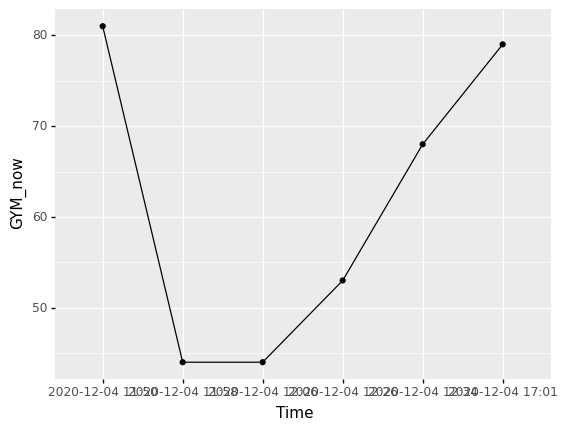

<ggplot: (17592043944066)>


In [17]:
# 折線圖
from plotnine import *
df_plot = pd.read_csv('NTU_GYM_Counter.csv')
# Reset Colnames
df_plot.columns = ["Time", "GYM_now", "GYM_optim", "GYM_max",
             "Pool_now", "Pool_optim", "Pool_max"]
base_plot = (ggplot(df_plot, aes(x = 'Time', y ='GYM_now', group = 1)) + 
             geom_line()+
             geom_point())
print(base_plot)

要存下來的圖

In [18]:
#df_plot

In [19]:
#ggplot(df_plot, aes(x='Time', y='GYM_now', group = 1)) + geom_line()

In [20]:
#Usage
#save(filename=None, format=None, path=None, width=None, height=None, units='in', dpi=None, limitsize=True, verbose=True, **kwargs)[source]¶
base_plot.save("/home/ubuntu/Python_Codes/work_out_timer/plot/plot.jpg")

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plot/plot.jpg


## Sending

1. 發送即時數據

2. 發送pattern的圖

In [21]:
def sendNotification(text = "", img_url = ""):
    
    token = "zTVbyzGgrcE5WOwiUQJoO38UdUYXvL1yI98TGyUDXwR"

    headers = {
        "Authorization": "Bearer " + token,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    
    params = {"message": text,
              "imageFullsize" : img_url,
              "imageThumbnail": img_url}

    r = requests.post("https://notify-api.line.me/api/notify",
                      headers=headers, params=params)
    print(r.status_code)  #200
    print("發送Line通知囉！")
    time.sleep(1)

In [22]:
#key = '健身中心現在人數'
#sendNotification(text = f"\n{key} : {count_dict[key]}", img_url = "")

### Imgur

* ID: 38382bd2f8f7299

* Secret: b6941cd41454d9c7d128e5f379536295b372460e

In [23]:
#!pip install pyimgur

* 參考：https://ithelp.ithome.com.tw/articles/10241006

```python
# Testing

#顯示在imgur的圖片
import pyimgur

CLIENT_ID = "38382bd2f8f7299"
im = pyimgur.Imgur(CLIENT_ID)
image = im.get_image('f1WHMuW')

print(image.title) 
print(image.link)
```

In [24]:
# Uploading

import pyimgur

CLIENT_ID = "38382bd2f8f7299"
PATH = "/home/ubuntu/Python_Codes/work_out_timer/plot/plot.jpg" #A Filepath to an image on your computer"
title = "Uploaded with PyImgur"

im = pyimgur.Imgur(CLIENT_ID)
uploaded_image = im.upload_image(PATH, title=title)
print(uploaded_image.title)
print(uploaded_image.link)
print(uploaded_image.type)

Uploaded with PyImgur
https://i.imgur.com/piTkt3F.jpg
image/jpeg


In [25]:
key = '健身中心現在人數'
sendNotification(text = f"\n{key} : {count_dict[key]}", 
                 img_url = uploaded_image.link)

200
發送Line通知囉！


In [1]:
driver.close()

NameError: name 'driver' is not defined